In [ ]:
#Trains the baseline model without RAI principles.

import pandas as pd

df = pd.read_excel("/home/jui/thesis-code/data/credit_card_clients.xls")
features = df.columns.tolist()

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from packaging import version
import sklearn
from sklearn.metrics import accuracy_score, classification_report


def split_label(dataset, target_feature):
    X = dataset.drop([target_feature], axis=1)
    y = dataset[[target_feature]]
    return X, y

# Handle different scikit-learn versions for OneHotEncoder parameters
if version.parse(sklearn.__version__) < version.parse('1.2'):
    ohe_params = {"sparse": False}
else:
    ohe_params = {"sparse_output": False}

def create_classification_pipeline(X):
    pipe_cfg = {
        'num_cols': X.dtypes[X.dtypes == 'int64'].index.values.tolist(),
        'cat_cols': X.dtypes[X.dtypes == 'object'].index.values.tolist(),
    }
    num_pipe = Pipeline([ 
        ('num_imputer', SimpleImputer(strategy='median')),
        ('num_scaler', StandardScaler())
    ])
    cat_pipe = Pipeline([
        ('cat_imputer', SimpleImputer(strategy='constant', fill_value='?')),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore', **ohe_params))
    ])
    feat_pipe = ColumnTransformer([
        ('num_pipe', num_pipe, pipe_cfg['num_cols']),
        ('cat_pipe', cat_pipe, pipe_cfg['cat_cols'])
    ])

    # Using XGBClassifier with Regularization, Learning Rate, and Eval Metrics
    xgb_model = xgb.XGBClassifier(
        tree_method='hist',  # Fast histogram-based training
        random_state=10,
        n_jobs=-1,  # Use all CPU cores
        learning_rate=0.16,  # Controls step size
        reg_lambda=1.1,  # L2 regularization (weight decay)
        eval_metric='logloss',
        objective='binary:logistic',  # Logarithmic loss for classification
        use_label_encoder=False,  # Avoids unnecessary warnings
        n_estimators=125
    )

    pipeline = Pipeline(steps=[('preprocessor', feat_pipe),
                               ('model', xgb_model)])

    return pipeline

/home/jui/.pyenv/versions/3.10.12/envs/myenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:28:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Accuracy: 0.8240
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      5860
           1       0.67      0.39      0.49      1640

    accuracy                           0.82      7500
   macro avg       0.76      0.67      0.69      7500
weighted avg       0.81      0.82      0.81      7500


Feature Names: ['num_pipe__ID' 'num_pipe__LIMIT_BAL' 'num_pipe__SEX'
 'num_pipe__EDUCATION' 'num_pipe__MARRIAGE' 'num_pipe__AGE'
 'num_pipe__PAY_0' 'num_pipe__PAY_2' 'num_pipe__PAY_3' 'num_pipe__PAY_4'
 'num_pipe__PAY_5' 'num_pipe__PAY_6' 'num_pipe__BILL_AMT1'
 'num_pipe__BILL_AMT2' 'num_pipe__BILL_AMT3' 'num_pipe__BILL_AMT4'
 'num_pipe__BILL_AMT5' 'num_pipe__BILL_AMT6' 'num_pipe__PAY_AMT1'
 'num_pipe__PAY_AMT2' 'num_pipe__PAY_AMT3' 'num_pipe__PAY_AMT4'
 'num_pipe__PAY_AMT5' 'num_pipe__PAY_AMT6']
Final Training Log Loss: 0.3043
Final Test Log Loss: 0.4250


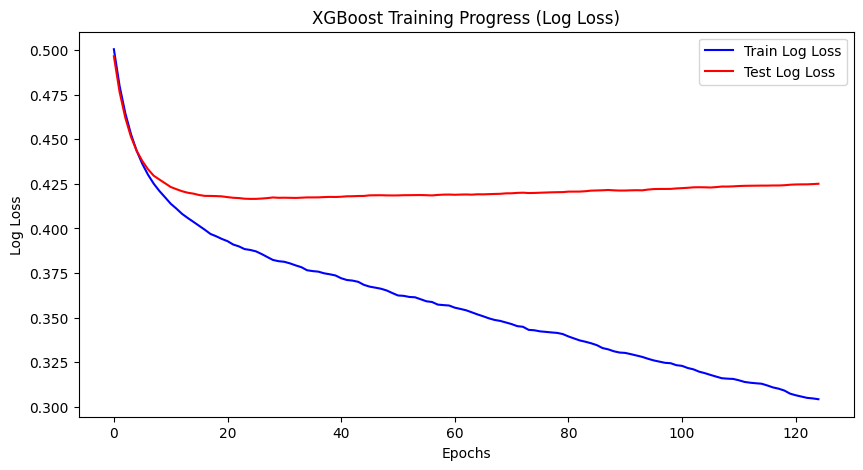

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pickle

# Load the saved train and test datasets from the files
with open('train_data_base.pkl', 'rb') as f:
    X_train_og, y_train_og = pickle.load(f)

with open('test_data_base.pkl', 'rb') as f:
    X_test, y_test = pickle.load(f)

y_train_og = y_train_og.squeeze() 

target_feature = 'default payment next month'
categorical_features = []

classes = np.unique(y_train_og).tolist() 


# Create the classification pipeline
pipeline = create_classification_pipeline(X_train_og)

# Fit the preprocessor separately to extract feature names
pipeline.named_steps['preprocessor'].fit(X_train_og)

# Extract transformed feature names safely
if hasattr(pipeline.named_steps['preprocessor'], "get_feature_names_out"):
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
else:
    # Manually construct feature names (for older sklearn versions)
    num_cols = X_train_og.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = X_train_og.select_dtypes(include=['object']).columns.tolist()
    feature_names = num_cols + cat_cols  # Not perfect, but works if get_feature_names_out() is missing

# Convert y_train and y_test to NumPy arrays
y_train_og = y_train_og.to_numpy()
y_test = y_test.to_numpy()

# Extract XGBClassifier separately and fit with eval_set
xgb_model = pipeline.named_steps['model']
model_baseline = xgb_model.fit(pipeline.named_steps['preprocessor'].transform(X_train_og), y_train_og, 
              eval_set=[(pipeline.named_steps['preprocessor'].transform(X_train_og), y_train_og),
                        (pipeline.named_steps['preprocessor'].transform(X_test), y_test)], verbose=False)

# Make prediction
y_pred_baseline = model_baseline.predict(pipeline.named_steps['preprocessor'].transform(X_test))

# Compute accuracy and classification report
accuracy = accuracy_score(y_test, y_pred_baseline)
class_report = classification_report(y_test, y_pred_baseline)

print(f"Model Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{class_report}\n")

# Extract evaluation results
evals_result = xgb_model.evals_result()

# Get the final log loss for training and testing
train_log_loss = evals_result['validation_0']['logloss'][-1]
test_log_loss = evals_result['validation_1']['logloss'][-1]

# Print the final log loss values for both training and validation
print(f"Final Training Log Loss: {train_log_loss:.4f}")
print(f"Final Test Log Loss: {test_log_loss:.4f}")

# Plot training and validation log loss
plt.figure(figsize=(10, 5))
plt.plot(evals_result['validation_0']['logloss'], label='Train Log Loss', color='blue')
plt.plot(evals_result['validation_1']['logloss'], label='Test Log Loss', color='red')
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.title("XGBoost Training Progress (Log Loss)")
plt.legend()
plt.show()